In [1]:
import sys
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import seaborn as sns
from h5py import File
import scienceplots

sys.path.insert(0, "/Users/rstiskalek/Projects/candel")
import candel
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


COLS = "#1be7ffff", "#6eeb83ff", "#e4ff1aff", "#ffb800ff", "#ff5714ff", "#9b5de5ff",
root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "VFO")

### Figure: Redshift distribution comparison

In [ ]:
import seaborn as sns
from candel import SPEED_OF_LIGHT


with File("/Users/rstiskalek/Projects/CANDEL/data/2MTF/PV_compilation.hdf5", 'r') as f:
    SFI = {}
    for key in f["SFI_gals"].keys():
        SFI[key] = f["SFI_gals"][key][...]

    TWOMTF = {}
    for key in f["2MTF"].keys():
        TWOMTF[key] = f["2MTF"][key][...]

    FOUNDATION = {}
    for key in f["Foundation"].keys():
        FOUNDATION[key] = f["Foundation"][key][...]

    LOSS = {}
    for key in f["LOSS"].keys():
        LOSS[key] = f["LOSS"][key][...]



with File("/Users/rstiskalek/Projects/CANDEL/data/CF4/CF4_TFR.hdf5", 'r') as f:
    CF4_TFR = {}
    grp = f["cf4"]
    for key in grp.keys():
        CF4_TFR[key] = grp[key][...]

    RA = grp["RA"][...] * 360 / 24
    CF4_TFR["RA"] = RA
    CF4_TFR["DEC"] = grp["DE"][...]

    l, b = candel.radec_to_galactic(CF4_TFR["RA"], CF4_TFR["DE"])
    m = np.abs(b) > 7.5
    for key in CF4_TFR.keys():
        CF4_TFR[key] = CF4_TFR[key][m]

In [ ]:
cols = COLS

with plt.style.context('science'):
    plt.rcParams.update({'font.size': 9})
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10/3, 3), sharex=True)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    bins = np.linspace(0, 0.07, 30)
    alpha = 0.5
    edge_width = 1.0

    # First row: Foundation and LOSS
    sns.histplot(FOUNDATION["z_CMB"], bins=bins, stat="count", alpha=alpha, label="Foundation", color=cols[1], edgecolor="black", ax=axes[0], linewidth=edge_width)
    sns.histplot(LOSS["z_CMB"], bins=bins, stat="count", alpha=alpha, label="LOSS", color=cols[0], edgecolor="black", ax=axes[0], linewidth=edge_width)
    axes[0].set_ylabel(None)
    axes[0].legend()

    # Second row: 2MTF and SFI
    sns.histplot(SFI["z_CMB"], bins=bins, stat="count", alpha=alpha, label="SFI", color=cols[2], edgecolor="black", ax=axes[1], linewidth=edge_width)
    sns.histplot(TWOMTF["z_CMB"], bins=bins, stat="count", alpha=alpha, label="2MTF", color=cols[3], edgecolor="black", ax=axes[1], linewidth=edge_width)
    axes[1].set_ylabel(None)
    axes[1].legend()

    # Third row: CF4 samples
    m_i = CF4_TFR["i"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_i] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_i"), color=cols[4], edgecolor="black", ax=axes[2], linewidth=edge_width)
    m_w1 = CF4_TFR["w1"] > 5
    sns.histplot(CF4_TFR["Vcmb"][m_w1] / SPEED_OF_LIGHT, 
                 bins=bins, stat="count", alpha=alpha, label=catalogue2label("CF4_TFR_w1"), color=cols[5], edgecolor="black", ax=axes[2], linewidth=edge_width)
    axes[2].set_xlabel(r"$z_{\rm obs}$")
    axes[2].set_ylabel(None)
    axes[2].legend()

    fig.text(0.03, 0.5, "Counts", va='center', ha='center', rotation='vertical')

    # Adjust layout
    plt.xlim(0, 0.07)
    plt.tight_layout(w_pad=0.2, h_pad=0.2)
    plt.savefig(f"/Users/rstiskalek/Downloads/zcmb_dist.pdf", dpi=450)
    plt.show()

### Figure: LOS comparison

In [ ]:
from astropy.coordinates import angular_separation

rootdir = "/Users/rstiskalek/Projects/CANDEL/data/CF4"
RA_virgo = np.deg2rad(candel.hms_to_degrees(12, 27)),
dec_virgo = np.deg2rad(candel.dms_to_degrees(12, 43))
dist_virgo = 16.5 * 0.73  # Mpc/h

k = None
data = {}
# reconstructions = ["CB2", "Carrick2015", "Lilow2024", "CF4", "CLONES"]
# reconstructions = ["Carrick2015", "Lilow2024", "CF4", "CLONES", "HAMLET", "CB2"]
# reconstructions = ["HAMLET_V1", "Carrick2015", "Lilow2024", "CF4", "CLONES", "manticore_2MPP_MULTIBIN_N256_DES_V2"]
reconstructions = ["Carrick2015", "HAMLET_V0", "HAMLET_V1", ]

for reconstruction in reconstructions:
    with File(join(rootdir, f"los_CF4_TFR_{reconstruction}.hdf5"), 'r') as f:
        if k is None:
            RA = np.deg2rad(f["RA"][...])
            dec = np.deg2rad(f["dec"][...])
            angdist = angular_separation(RA, dec, RA_virgo, dec_virgo)
            # k = np.argmin(angdist) + 500
            k = np.random.choice(np.arange(0, len(angdist)))

        r = f["r"][...]
        rho = f["los_density"][:, k, :]
        vel = f["los_velocity"][:, k, :]

        if reconstruction == "Carrick2015":
            vel *= 0.43

        data[reconstruction] = [r, rho, vel]

In [ ]:
gen = np.random.default_rng(43)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6, 4))
    lw = plt.rcParams["lines.linewidth"]

    for simname in reconstructions:
        r, rho, vel = data[simname]  # vel: (nsamples, nr)
        y = vel


        col = simname2color(simname, gen)
        if vel.shape[0] > 1:
            ylow, yhigh = np.percentile(y, [16, 84], axis=0)
            ax.fill_between(r, ylow, yhigh, alpha=0.75,
                            label=simname2label(simname), color=col)
        else:
            ax.plot(r, y[0], lw=1.5 * lw, label=simname2label(simname),
                    color=col)

    ax.set_xlabel(r"$r~[h^{-1}\,\mathrm{Mpc}]$")
    ax.set_ylabel(r"$V_{\rm rad}~[\mathrm{km}\,\mathrm{s}^{-1}]$")

    ax.set_xlim(r.min(), 90)
    # ax.set_ylim(-600, 1050)

    ax.axvline(dist_virgo, zorder=0, c="k", ls="--", alpha=0.75)

    ax.legend(ncols=3, loc="upper right", fontsize="small", handlelength=1.75)

    fig.tight_layout()
    fig.savefig(f"/Users/rstiskalek/Downloads/LOS_{k}.png", dpi=450)
    plt.show()

### Test..

In [2]:
def switch_paths_SN_to_no_MNR(files):
    new_files = []
    for name, paths in files:
        new_paths = []
        for p in paths:
            if "LOSS" in p or "Foundation" in p:
                new_paths.append(p.replace("MNR", "noMNR"))
            else:
                new_paths.append(p)
        new_files.append((name, new_paths))
    return new_files


def load_and_clean_logZ(files, samples, stat="logZ_harmonic"):
    if not stat.startswith("logZ"):
        raise ValueError("Invalid statistic name.")

    gof = np.array([
        [candel.read_gof(f, stat, raise_error=False) for f in fs]
        for _, fs in files
    ])

    # Replace non-finite with NaN
    gof[~np.isfinite(gof)] = np.nan

    Nsim, Ncat = gof.shape
    for i in range(Nsim):
        simname, _ = files[i]
        for j in range(Ncat):
            if np.isnan(gof[i, j]):
                print(f"LogZ [NaN] sim = {simname} | catalogue = {samples[j]} | filename = {files[i][1][j]}")

    # Subtract per-column minimum
    gof -= np.nanmin(gof, axis=0, keepdims=True)

    return gof

def strip_token_from_paths(files, token):
    new_files = []
    for name, paths in files:
        new_paths = [p.replace(f"_{token}", "") for p in paths]
        new_files.append((name, new_paths))
    return new_files

In [11]:
samples = ["LOSS", "Foundation", "SFI", "2MTF", "CF4_W1", "CF4_i"]

files = [
    ["CB2", [join(root, f"precomputed_los_CB2_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ["Lilow2024", [join(root, f"precomputed_los_Lilow2024_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ["Carrick2015", [join(root, f"precomputed_los_Carrick2015_{sample}_MNR_linear_from_beta_stochastic.hdf5") for sample in samples]],
    ["CB1", [join(root, f"precomputed_los_CB1_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    # ["HAMLET_V0", [join(root, f"precomputed_los_HAMLET_V0_{sample}_MNR_linear_beta_1.0.hdf5") for sample in samples]],
    ["CF4", [join(root, f"precomputed_los_CF4_{sample}_MNR_linear_beta_1.0.hdf5") for sample in samples]],
    ["CLONES", [join(root, f"precomputed_los_CLONES_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    # ["HAMLET_V1", [join(root, f"precomputed_los_HAMLET_V1_{sample}_MNR_double_powerlaw_beta_1.0.hdf5") for sample in samples]],
    ]

files = switch_paths_SN_to_no_MNR(files)
gof = load_and_clean_logZ(files, samples)




LogZ [NaN] sim = CF4 | catalogue = CF4_i | filename = /Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_CF4_CF4_i_MNR_linear_beta_1.0.hdf5


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_44980/2587959320.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


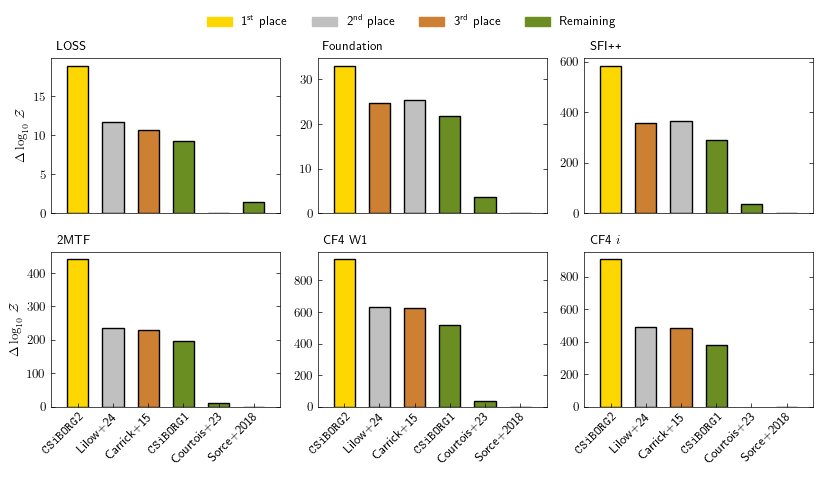

In [12]:
def _top3_colors(vals):
    finite = np.isfinite(vals)
    cols = ["lightgray" if not ok else "olivedrab" for ok in finite]

    if not finite.any():
        return cols  # no winners if column is entirely NaN

    # Rank only finite entries
    order = np.argsort(vals[finite])[::-1]
    idxs = np.where(finite)[0][order]

    if len(idxs) >= 1: cols[idxs[0]] = "#FFD700"  # gold
    if len(idxs) >= 2: cols[idxs[1]] = "#C0C0C0"  # silver
    if len(idxs) >= 3: cols[idxs[2]] = "#CD7F32"  # bronze
    return cols

# Reconstruction names in the same order as rows of gof
rec_names = [name for name, _ in files]
Ns = len(rec_names)
assert gof.shape == (Ns, len(samples)), "gof shape must be (Nrec, 6)."

# Make Δlog10 Z per catalogue (column-normalised)
y = gof.copy()                         # (Nrec, 6)

# Plot: always 6 catalogues → 2x3 grid; arbitrary number of reconstructions (bars per panel)
with plt.style.context("science"):
    plt.rcParams.update({"font.size": 9})
    figwidth = 8.3
    fig, axs = plt.subplots(2, 3, figsize=(figwidth, 0.55 * figwidth))
    fig.subplots_adjust(hspace=0, wspace=0)

    x = np.arange(Ns)
    bar_w = 0.6 if Ns <= 8 else 0.45  # a touch narrower if many reconstructions

    for n, cat in enumerate(samples[:6]):
        i, j = divmod(n, 3)
        ax = axs[i, j]

        ax.text(0.025, 1.075, catalogue2label(cat),
                transform=ax.transAxes, va="center", ha="left",
                bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=3),
                zorder=5)

        cols = _top3_colors(y[:, n])
        for xi in range(Ns):
            ax.bar(x[xi], y[xi, n], width=bar_w, color=cols[xi],
                   edgecolor="k", zorder=-1)

        ax.set_xlim(-0.75, Ns - 0.25)

        # x tick labels only on bottom row
        if i == 1:
            ax.set_xticks(np.arange(Ns), [simname2label(s) for s in rec_names],
                          rotation=45, ha="right")
            # nudge labels slightly right
            offset = mtransforms.ScaledTranslation(5 / 72, 0, fig.dpi_scale_trans)
            for lab in ax.get_xticklabels():
                lab.set_transform(lab.get_transform() + offset)
        else:
            ax.set_xticks([], [])

        ax.tick_params(axis="x", which="major", top=False)
        ax.tick_params(axis="x", which="minor", top=False, length=0)
        ax.tick_params(axis="y", which="minor", length=0)

    for i in range(2):
        axs[i, 0].set_ylabel(r"$\Delta \log_{10}\,\mathcal{Z}$")

    # Legend for ranking colors
    gold   = mpatches.Patch(color="#FFD700", label=r"1\textsuperscript{st} place")
    silver = mpatches.Patch(color="#C0C0C0", label=r"2\textsuperscript{nd} place")
    bronze = mpatches.Patch(color="#CD7F32", label=r"3\textsuperscript{rd} place")
    green  = mpatches.Patch(color="olivedrab", label=r"Remaining")
    fig.legend(handles=[gold, silver, bronze, green],
               loc="upper center", bbox_to_anchor=(0.5, 1.05),
               ncol=4, frameon=False)

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/gof_plot.png", dpi=300)
    fig.show()

In [13]:
def load_and_check_posteriors(files, samples, key):
    data = {}
    Nsim = len(files)
    Ncat = len(samples)

    for i in range(Nsim):
        simname, paths = files[i]
        for j in range(Ncat):
            cat = samples[j]
            fname = paths[j]

            try:
                arr = candel.read_samples("", fname, keys=key)  # fname is already a full path
            except Exception as e:
                raise ValueError(f"Samples for {key} [NaN/empty] sim={simname} | catalogue={cat} | filename={fname}") from e

            data[(simname, cat)] = arr

    return data

### Figure: $V_{\rm ext}$ comparison

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_44980/3018678876.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


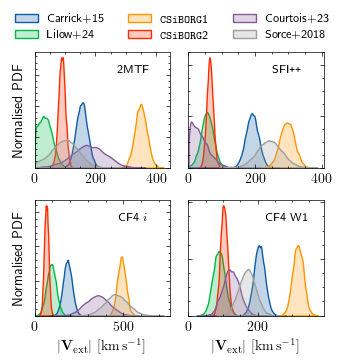

In [23]:
data = load_and_check_posteriors(files, samples, "Vext_mag")

sims = ["Carrick2015", "Lilow2024", "CB1", "CB2", "CF4", "CLONES"]
cats = ["2MTF", "SFI", "CF4_i", "CF4_W1"]


with plt.style.context('science'):
    ncols, nrows = 2, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.5, 2.65 * 1.25))
    fig.subplots_adjust(hspace=0, wspace=0)

    for k, cat in enumerate(cats):
        i, j = divmod(k, ncols)
        ax = axs[i, j]
        for sim in sims:
            arr = data.get((sim, cat))
            if arr is None or np.size(arr) == 0:
                continue
            arr = np.asarray(arr).ravel()
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue

            sns.kdeplot(
                arr, fill=True, bw_adjust=0.75, ax=ax,
                clip=(0, np.inf),  # restrict support to [0, ∞)
                cut=0,              # don't extend past the data
                color=simname2color(sim),
                label=simname2label(sim) if i == 0 else None
            )

        ax.text(
            0.725, 0.85, catalogue2label(cat),
            transform=ax.transAxes, fontsize="small",
            va='center', ha='center',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
        ax.set_ylabel(None)
        ax.set_yticklabels([])
        ax.set_xlim(left=0)

    # Legend from first row
    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles, labels, loc='upper center',
            bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False,
            fontsize="small")

    for c in range(ncols):
        axs[-1, c].set_xlabel(r"$|\mathbf{V}_{\rm ext}|~[\mathrm{km}\,\mathrm{s}^{-1}]$")
    for r in range(nrows):
        axs[r, 0].set_ylabel("Normalised PDF")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/Vext_comparison.pdf", dpi=450, bbox_inches="tight")
    fig.show()